### Perform FFT

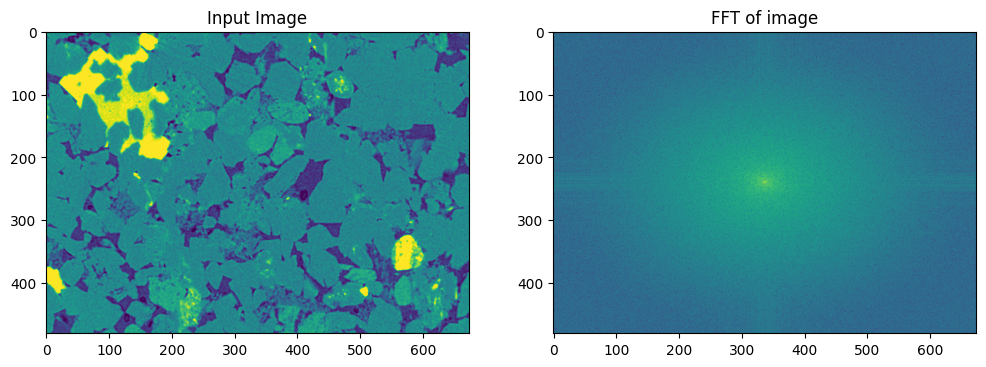

In [2]:
#Video Playlist: https://www.youtube.com/playlist?list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG

import cv2
from matplotlib import pyplot as plt
import numpy as np

#Generate a 2D sine wave image
x = np.arange(256)  # generate values from 0 to 255 (our image size)
y = np.sin(2 * np.pi * x / 3)  #calculate sine of x values
#Divide by a smaller number above to increase the frequency.
y += max(y) # offset sine wave by the max value to go out of negative range of sine 

#Generate a 256x256 image (2D array of the sine wave)
img = np.array([[y[j]*127 for j in range(256)] for i in range(256)], dtype=np.uint8) # create 2-D array of sine-wave

#plt.imshow(img)
#img = np.rot90(img)  #Rotate img by 90 degrees

img = cv2.imread('C:/JupyterLab/github_repos/NLP_project/Images/fourier_images/sandstone.tif', 0) # load an image

dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

#Shift DFT. First check the output without the shift
#Without shifting the data would be centered around origin at the top left
#Shifting it moves the origin to the center of the image. 
dft_shift = np.fft.fftshift(dft)

#Calculate magnitude spectrum from the DFT (Real part and imaginary part)
#Added 1 as we may see 0 values and log of 0 is indeterminate
magnitude_spectrum = 20 * np.log((cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))+1)


#As the spatial frequency increases (bars closer), 
#the peaks in the DFT amplitude spectrum move farther away from the origin

#Center represents low frequency and the corners high frequency (with DFT shift).
#To build high pass filter block center corresponding to low frequencies and let
#high frequencies go through. This is nothing but an edge filter. 

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img)
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(magnitude_spectrum)
ax2.title.set_text('FFT of image')
plt.show()

C:\Users\gustavo220061\AppData\Local\Temp\ipykernel_22380\341449960.py:76: RuntimeWarning: divide by zero encountered in log
  fshift_mask_mag = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))


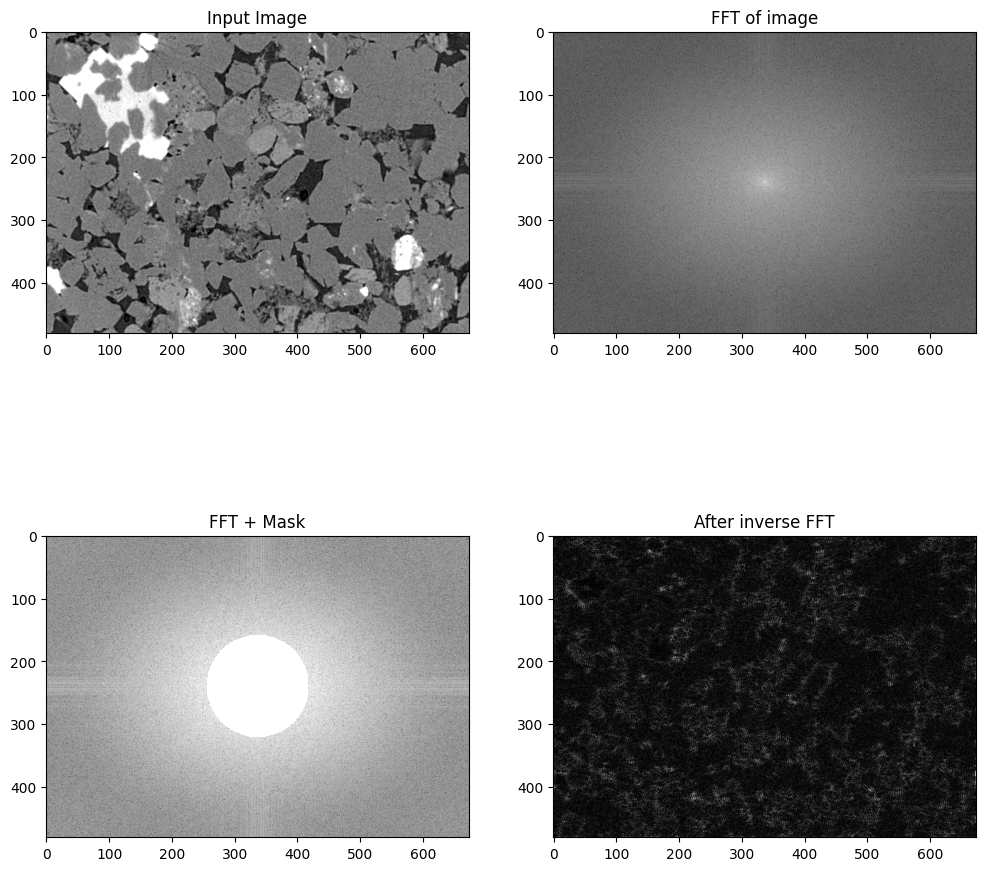

In [3]:
#Video Playlist: https://www.youtube.com/playlist?list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG

import cv2
from matplotlib import pyplot as plt
import numpy as np


img = cv2.imread('C:/JupyterLab/github_repos/NLP_project/Images/fourier_images/sandstone.tif', 0) # load an image

#Output is a 2D complex array. 1st channel real and 2nd imaginary
#For fft in opencv input image needs to be converted to float32
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

#Rearranges a Fourier transform X by shifting the zero-frequency 
#component to the center of the array.
#Otherwise it starts at the tope left corenr of the image (array)
dft_shift = np.fft.fftshift(dft)

##Magnitude of the function is 20.log(abs(f))
#For values that are 0 we may end up with indeterminate values for log. 
#So we can add 1 to the array to avoid seeing a warning. 
magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))


# Circular HPF mask, center circle is 0, remaining all ones
#Can be used for edge detection because low frequencies at center are blocked
#and only high frequencies are allowed. Edges are high frequency components.
#Amplifies noise.

rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)

mask = np.ones((rows, cols, 2), np.uint8)
r = 80
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
mask[mask_area] = 0


# Circular LPF mask, center circle is 1, remaining all zeros
# Only allows low frequency components - smooth regions
#Can smooth out noise but blurs edges.
#
"""
rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)

mask = np.zeros((rows, cols, 2), np.uint8)
r = 100
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
mask[mask_area] = 1

# Band Pass Filter - Concentric circle mask, only the points living in concentric circle are ones
rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)

mask = np.zeros((rows, cols, 2), np.uint8)
r_out = 80
r_in = 10
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = np.logical_and(((x - center[0]) ** 2 + (y - center[1]) ** 2 >= r_in ** 2),
                           ((x - center[0]) ** 2 + (y - center[1]) ** 2 <= r_out ** 2))
mask[mask_area] = 1
"""


# apply mask and inverse DFT: Multiply fourier transformed image (values)
#with the mask values. 
fshift = dft_shift * mask

#Get the magnitude spectrum (only for plotting purposes)
fshift_mask_mag = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))

#Inverse shift to shift origin back to top left.
f_ishift = np.fft.ifftshift(fshift)

#Inverse DFT to convert back to image domain from the frequency domain. 
#Will be complex numbers
img_back = cv2.idft(f_ishift)

#Magnitude spectrum of the image domain
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])



fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(magnitude_spectrum, cmap='gray')
ax2.title.set_text('FFT of image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(fshift_mask_mag, cmap='gray')
ax3.title.set_text('FFT + Mask')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(img_back, cmap='gray')
ax4.title.set_text('After inverse FFT')
plt.show()

### Histogram Equaization

In [4]:
#Video Playlist: https://www.youtube.com/playlist?list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG

"""
Histogram equalization: 
Stretches histogram to include all ranges if the original histogram is confined
only to a small region - low contrast images. 
But, this type of stretching may not result in ideal results and gives 
too bright and too dark regions in the image. This can be very bad for images
with large intensity variations. 

CLAHE: COntrast limited adaptive histogram equalization
Regular histogram equalization uses global contrast of the image. This results in
too bright and too dark regions as the histogram stretches and is not confined
to specific region.

Adaptive histogram equalization divides the image into small tiles and within 
each tile the histogram is equalized. Tile size is typically 8x8. 
If theimage contains noise, it gets amplified during this process. Therefore, 
contrast limiting is applied to limit the contrast below a specific limit.
Bilinear interpolation is performed between tile borders. 

Below, let us perform both histogram equalization and CLAHE and compare the results. 
The best way to work with color images is by converting them to luminance space,
e.g. LAB, and enhancing lumincnace channel only and eventually combining all channels. 
    
"""

import cv2
from skimage import io
from matplotlib import pyplot as plt

img = cv2.imread("C:/JupyterLab/github_repos/NLP_project/Images/fourier_images/sandstone_low_contrast.tif", 1)

#img = cv2.imread('C:/JupyterLab/github_repos/NLP_project/Images/fourier_images/retina.jpg', 1)

#Converting image to LAB Color so CLAHE can be applied to the luminance channel
lab_img= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

#Splitting the LAB image to L, A and B channels, respectively
l, a, b = cv2.split(lab_img)

#plt.hist(l.flat, bins=100, range=(0,255))
###########Histogram Equlization#############
#Apply histogram equalization to the L channel
equ = cv2.equalizeHist(l)

#plt.hist(equ.flat, bins=100, range=(0,255))
#Combine the Hist. equalized L-channel back with A and B channels
updated_lab_img1 = cv2.merge((equ,a,b))

#Convert LAB image back to color (RGB)
hist_eq_img = cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)

###########CLAHE#########################
#Apply CLAHE to L channel
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
clahe_img = clahe.apply(l)
#plt.hist(clahe_img.flat, bins=100, range=(0,255))

#Combine the CLAHE enhanced L-channel back with A and B channels
updated_lab_img2 = cv2.merge((clahe_img,a,b))

#Convert LAB image back to color (RGB)
CLAHE_img = cv2.cvtColor(updated_lab_img2, cv2.COLOR_LAB2BGR)

cv2.imshow("Original image", img)
cv2.imshow("Equalized image", hist_eq_img)
cv2.imshow('CLAHE Image', CLAHE_img)
cv2.waitKey(0)
cv2.destroyAllWindows() 

### Shading correction (rolling ball)

In [5]:
#Video Playlist: https://www.youtube.com/playlist?list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG


"""
1st approach: Perform CLAHE
# Equalize light by performing CLAHE on the Luminance channel
# The equalize part alreay covered as aprt of previous tutorials about CLAHE
# This kind of works but you can still see shading after the correction.

2nd approach:
Apply rolling ball background subtraction
pip install opencv-rolling-ball

"""
import cv2
import numpy as np

img = cv2.imread("C:/JupyterLab/github_repos/NLP_project/Images/fourier_images/Ti_powder.tif", 1)

lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab_img)


clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8,8))
clahe_img = clahe.apply(l)
CLAHE_img = cv2.merge((clahe_img,a,b))

corrected_image = cv2.cvtColor(CLAHE_img, cv2.COLOR_LAB2BGR)

cv2.imshow("Original image", img)
cv2.imshow("Corrected image", corrected_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# TO DO: ADAPT
"""
#2nd method
# https://pypi.org/project/opencv-rolling-ball/
# 
# pip install opencv-rolling-ball
# Only works with 8 bit grey

A local background value is determined for every pixel by averaging over a 
very large ball around the pixel. This value is then subtracted from 
the original image, removing large spatial variations of the 
background intensities. The radius should be set to at least the size of the 
largest object that is not part of the background.
"""

import cv2
from cv2_rolling_ball import subtract_background_rolling_ball
from matplotlib import pyplot as plt

img = cv2.imread("images/Particle_gradient.jpg", 0)

radius=20
final_img, background = subtract_background_rolling_ball(img, radius, light_background=True,
                                     use_paraboloid=False, do_presmooth=True)


#optionally perform CLAHE to equalize histogram for better segmentation
#otherwise the image may appear washedout. 

clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8,8))
clahe_img = clahe.apply(final_img)

#cv2.imshow("Original image", img)
cv2.imshow("Background image", background)
cv2.imshow("AFter background subtraction", final_img)
cv2.imshow("After CLAHE", clahe_img)

cv2.waitKey(0)
cv2.destroyAllWindows()

### Color spaces

In [6]:
#Video Playlist: https://www.youtube.com/playlist?list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG

"""
Color spaces
RGB - Red, Green, Blue 
HSV - Hue, Saturation, Value
LAB - Lightness, A (Green to red), B (Blue to Yellow)

"""

import cv2
from skimage import io


#Needs 8 bit, not float.
color_opencv = cv2.imread('C:/JupyterLab/github_repos/NLP_project/Images/fourier_images/Osteosarcoma_01.tif', 1)
gray_opencv = cv2.imread('C:/JupyterLab/github_repos/NLP_project/Images/fourier_images/Osteosarcoma_01.tif', 0)

color_skimage = io.imread('C:/JupyterLab/github_repos/NLP_project/Images/fourier_images/Osteosarcoma_01.tif', as_gray=False)
gray_skimage = io.imread('C:/JupyterLab/github_repos/NLP_project/Images/fourier_images/Osteosarcoma_01.tif', as_gray=True)

B, G, R = cv2.split(color_opencv)


cv2.imshow("Original", color_opencv)
cv2.imshow("B", B)
cv2.imshow("G", G)
cv2.imshow("R", R)


cv2.waitKey(0)          
cv2.destroyAllWindows() 

In [7]:
##########################################################


hsv_image = cv2.cvtColor(color_skimage, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv_image)

cv2.imshow("Original", color_opencv)
cv2.imshow("h", h)
cv2.imshow("s", s)
cv2.imshow("v", v)


cv2.waitKey(0)          
cv2.destroyAllWindows() 

#####################################


In [8]:
lab_image = cv2.cvtColor(color_skimage, cv2.COLOR_BGR2LAB)
L, A, B = cv2.split(lab_image)

cv2.imshow("Original", color_opencv)
cv2.imshow("L", L)
cv2.imshow("A", A)
cv2.imshow("B", B)


cv2.waitKey(0)          
cv2.destroyAllWindows() 

############################################

### Gray scale filters

In [9]:
#Video Playlist: https://www.youtube.com/playlist?list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG

"""

There are many filters that are designed to work with gray-scale 
images but not with color images. 
To simplify the process of creating functions that can adapt to RGB images, 
scikit-image provides the adapt_rgb decorator.

NOTE: A decorator in Python is any callable Python object that is 
used to modify a function or a class.
"""

from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters
from skimage import io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

image = io.imread("C:/JupyterLab/github_repos/NLP_project/Images/fourier_images/monalisa.jpg")

try_to_apply_sobel = filters.sobel(image)
#Fails on color images as it is a grey filter

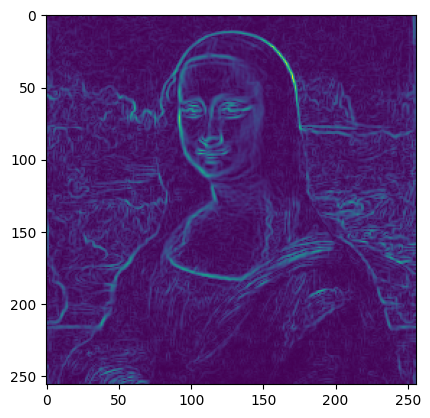

In [10]:
#Two ways to apply the filter on color images
#1. Separate R, G and B channels and apply the filter to each channel and put the channel back together.
#2. Convert RGB to HSV and then apply filter to V channel and put it back to HSV and convert to RGB.

#Too many lines of code to do these tasks but with adapt_rgb decorator the task becomes easy.

@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)


@adapt_rgb(hsv_value)
def sobel_hsv(image):
    return filters.sobel(image)


each_channel_image = sobel_each(image)
hsv_value_image = sobel_hsv(image)

#Convert to grey if needed

sobel_grey = rgb2gray(hsv_value_image)

plt.imshow(sobel_grey)

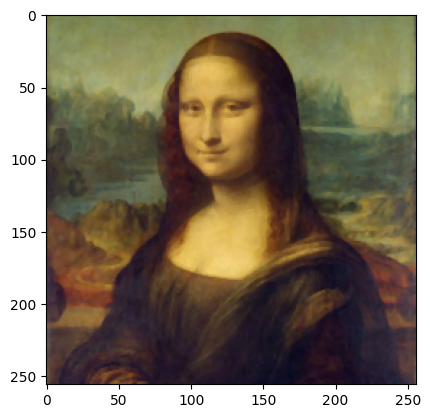

In [11]:
#################################
#The decorators work on any function, including
#the ones using opencv filters
import cv2

@adapt_rgb(each_channel)
def median_each(image, k):
    output_image = cv2.medianBlur(image, k)
    return (output_image)

median_using_cv2 = median_each(image, 3)
plt.imshow(median_using_cv2)

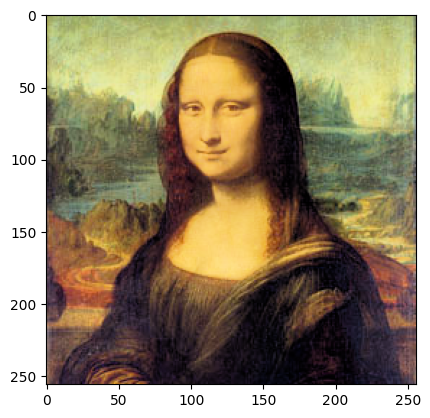

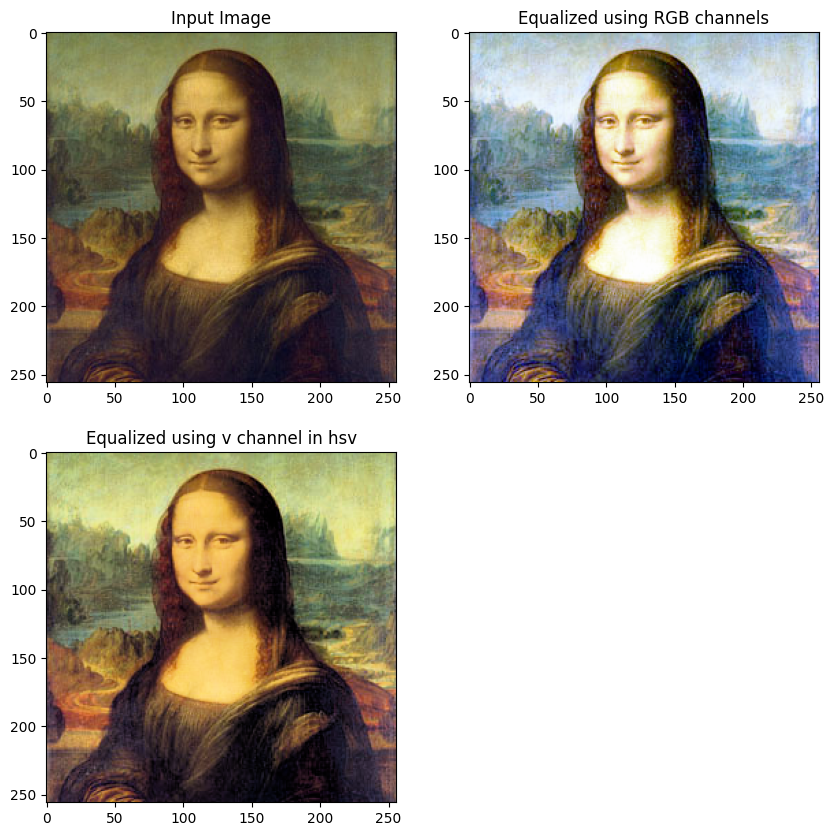

In [12]:
##############################################

#Histogram equalization on RGB channels will yield non-ideal results
#Applying it on V channel in HSV provies the best results

from skimage import exposure

@adapt_rgb(each_channel)
def eq_each(image):
    output_image = exposure.equalize_hist(image)
    return (output_image)

equ_RGB = eq_each(image)
plt.imshow(equ_RGB)


@adapt_rgb(hsv_value)
def eq_hsv(image):
    output_image = exposure.equalize_hist(image)
    return (output_image)

equ_hsv = eq_hsv(image)
plt.imshow(equ_hsv)


fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(image)
ax1.title.set_text('Input Image')

ax2 = fig.add_subplot(2,2,2)
ax2.imshow(equ_RGB)
ax2.title.set_text('Equalized using RGB channels')

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(equ_hsv)
ax3.title.set_text('Equalized using v channel in hsv')

plt.show()

### Image Registration

In [ ]:
# TO DO: ADAPT
"""
Learning from the astronomy guys...
A couple of ways to perform image registration
https://image-registration.readthedocs.io/en/latest/image_registration.html

pip install image_registration
"""
from skimage import io
from image_registration import chi2_shift

image = io.imread("images/Osteosarcoma_01.tif", as_gray=True)
offset_image = io.imread("images/Osteosarcoma_01_transl.tif", as_gray=True)
# offset image translated by (-17, 18.) in y and x 



#Method 1: chi squared shift
#Find the offsets between image 1 and image 2 using the DFT upsampling method
# 2D rigid

noise=0.1
xoff, yoff, exoff, eyoff = chi2_shift(image, offset_image, noise, 
                                      return_error=True, upsample_factor='auto')

print("Offset image was translated by: 18, -17")
print("Pixels shifted by: ", xoff, yoff)

from scipy.ndimage import shift
corrected_image = shift(offset_image, shift=(-xoff,-yoff), mode='constant')

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(image, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(offset_image, cmap='gray')
ax2.title.set_text('Offset image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(corrected_image, cmap='gray')
ax3.title.set_text('Corrected')
plt.show()


In [ ]:
# TO DO: ADAPT
###########################################################################
#Method 2: Cross correlation based shift
#Use cross-correlation and a 2nd order taylor expansion to measure the shift
#2D rigid

from skimage import io
from image_registration import cross_correlation_shifts

image = io.imread("images/Osteosarcoma_01.tif", as_gray=True)
offset_image = io.imread("images/Osteosarcoma_01_transl.tif", as_gray=True)
# offset image translated by (-17, 18) in y and x 


xoff, yoff = cross_correlation_shifts(image, offset_image)


print("Offset image was translated by: 18, -17")
print("Pixels shifted by: ", xoff, yoff)


from scipy.ndimage import shift
corrected_image = shift(offset_image, shift=(-xoff,-yoff), mode='constant')

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(image, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(offset_image, cmap='gray')
ax2.title.set_text('Offset image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(corrected_image, cmap='gray')
ax3.title.set_text('Corrected')
plt.show()

Offset image was translated by: 18, -17
Pixels shifted by:  18.0 -17.0


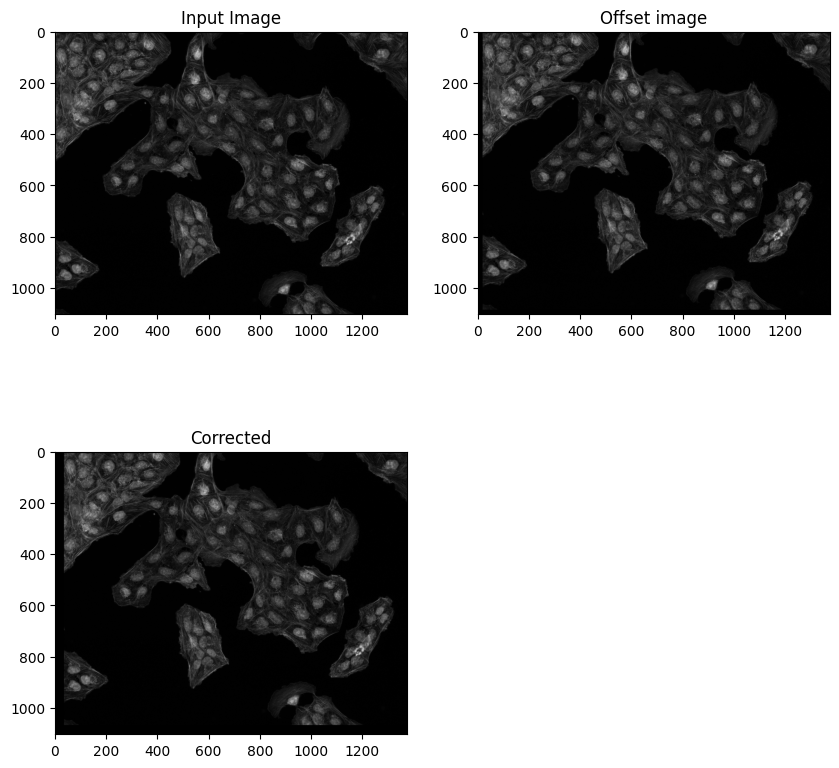

In [13]:
#Method 3: Register translation from skimage.feature
#2D rigid, same as cross correlation. 
#Depreciated in the latest skimage (0.18.0). 
#Latest version use: skimage.registration.phase_cross_correlation

from skimage import io

image = io.imread("C:/JupyterLab/github_repos/NLP_project/Images/fourier_images/Osteosarcoma_01.tif", as_gray=True)
offset_image = io.imread("C:/JupyterLab/github_repos/NLP_project/Images/fourier_images/Osteosarcoma_01_transl.tif", as_gray=True)
# offset image translated by (-17, 18) in y and x 


from skimage.registration import phase_cross_correlation
shifted, error, diffphase = phase_cross_correlation(image, offset_image, upsample_factor=100)
xoff = -shifted[1]
yoff = -shifted[0]


print("Offset image was translated by: 18, -17")
print("Pixels shifted by: ", xoff, yoff)


from scipy.ndimage import shift
corrected_image = shift(offset_image, shift=(-xoff,-yoff), mode='constant')

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(image, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(offset_image, cmap='gray')
ax2.title.set_text('Offset image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(corrected_image, cmap='gray')
ax3.title.set_text('Corrected')
plt.show()



Offset image was translated by: 18, -17
Pixels shifted by:  18.014914 -17.005634


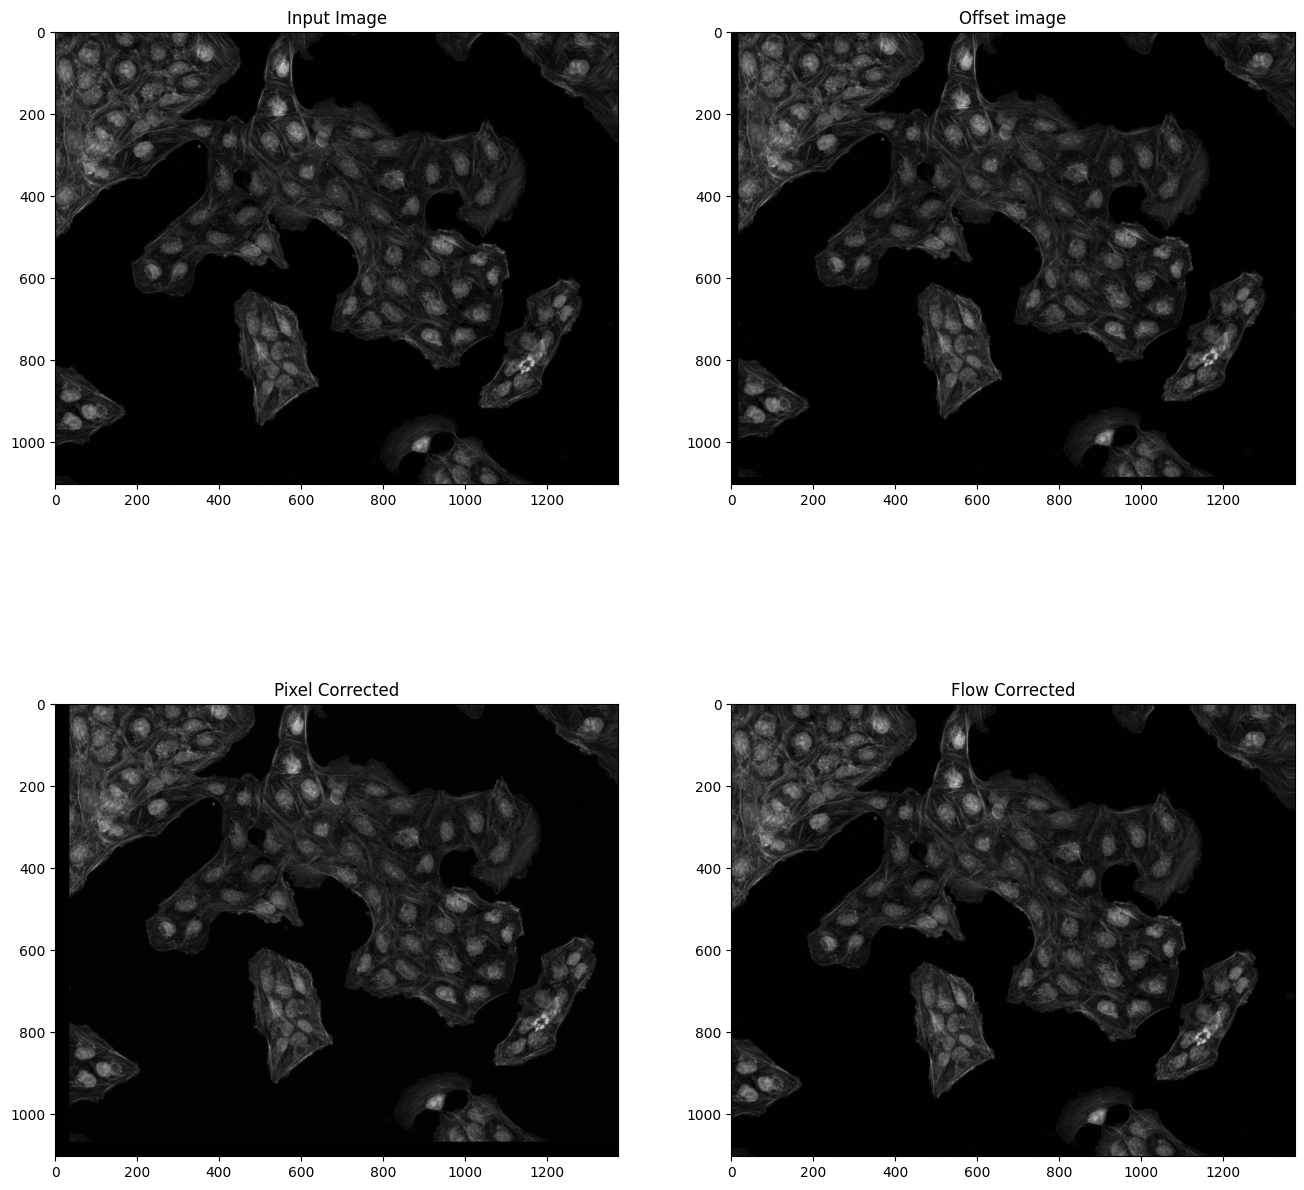

In [14]:
############################################################
#Method 4: Optical flow based shift. Best for warped images. 
#takes two images and returns a vector field. 
#For every pixel in image 1 you get a vector showing where it moved to in image 2.

from skimage import io

image = io.imread("C:/JupyterLab/github_repos/NLP_project/Images/fourier_images/Osteosarcoma_01.tif", as_gray=True)
offset_image = io.imread("C:/JupyterLab/github_repos/NLP_project/Images/fourier_images/Osteosarcoma_01_transl.tif", as_gray=True)
# offset image translated by (-17, 18) in y and x 


from skimage import registration
flow = registration.optical_flow_tvl1(image, offset_image)

# display dense optical flow
flow_x = flow[1, :, :]  #Along width
flow_y = flow[0, :, :]  #Along height


#Example 1: Simple application by just taking mean of flow in x and y
#Let us find the mean of all pixels in x and y and shift image by that amount
#ideally, you need to move each pixel by the amount from flow
import numpy as np
xoff = np.mean(flow_x)
yoff = np.mean(flow_y)


print("Offset image was translated by: 18, -17")
print("Pixels shifted by: ", xoff, yoff)

from scipy.ndimage import shift
corrected_image = shift(offset_image, shift=(-xoff,-yoff), mode='constant')


#Example 2: Applying flow vectors to each pixel 

height, width = image.shape

#Use meshgrid to Return coordinate matrices from coordinate vectors.
#Extract row and column coordinates to which flow vector values will be added.
row_coords, col_coords = np.meshgrid(np.arange(height), np.arange(width),
                                     indexing='ij')   #Matrix indexing

#For each pixel coordinate add respective flow vector to transform
from skimage.transform import warp
image1_warp = warp(offset_image, np.array([(row_coords + flow_y), (col_coords + flow_x)]),
                   mode='edge')


from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(image, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(offset_image, cmap='gray')
ax2.title.set_text('Offset image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(corrected_image, cmap='gray')
ax3.title.set_text('Pixel Corrected')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(image1_warp, cmap='gray')
ax4.title.set_text('Flow Corrected')
plt.show()


##################################################

### Image Register (Pystackreg)

In [ ]:
#TO DO: NEW; ADAPT
#Video Playlist: https://www.youtube.com/playlist?list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG

"""
Image registration using pystackreg
https://pypi.org/project/pystackreg/

pip install pystackreg

pyStackReg is used to align (register) one or more images to a 
common reference image, as is required usually in time-resolved fluorescence 
or wide-field microscopy. 

It uses functionality from imageJ

pyStackReg provides the following four types of distortion:

1. translation
2. rigid body (translation + rotation)
3. scaled rotation (translation + rotation + scaling)
4. affine (translation + rotation + scaling + shearing)
5. bilinear (non-linear transformation; does not preserve straight lines)

"""

from pystackreg import StackReg
from skimage import io
from matplotlib import pyplot as plt


#The following example opens two different files and registers them 
#using all different possible transformations

#load reference and "moved" image
ref_img = io.imread('images/for_alignment/translated/shale_for_alignment00.tif')
offset_img = io.imread('images/for_alignment/translated/shale_for_alignment01.tif')

#Translational transformation
sr = StackReg(StackReg.TRANSLATION)  #Create an operator first
out_tra = sr.register_transform(ref_img, offset_img)  #Apply the operator
plt.imshow(out_tra, cmap='gray')


#Rigid Body transformation
sr = StackReg(StackReg.RIGID_BODY)
out_rot = sr.register_transform(ref_img, offset_img)

#Scaled Rotation transformation
#sr = StackReg(StackReg.SCALED_ROTATION)
#out_sca = sr.register_transform(ref_img, offset_img)

#Affine transformation
sr = StackReg(StackReg.AFFINE)
out_aff = sr.register_transform(ref_img, offset_img)


#Plotting a few outputs

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(ref_img, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(out_tra, cmap='gray')
ax2.title.set_text('Translation')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(out_rot, cmap='gray')
ax3.title.set_text('Rigid Body')
ax3 = fig.add_subplot(2,2,4)
ax3.imshow(out_aff, cmap='gray')
ax3.title.set_text('Affine')
plt.show()



#Looking at single image doesn't make sense for this example.
#Let us look at a stack


#############################################
#To create a tiff stack image from individual images

import glob
import tifffile

with tifffile.TiffWriter('images/for_alignment/my_image_stack.tif') as stack:
    for filename in glob.glob('images/for_alignment/translated/*.tif'):
        stack.save(tifffile.imread(filename))

####################################################################

#How to register and transform a whole stack:

from pystackreg import StackReg
from skimage import io

img0 = io.imread('images/for_alignment/my_image_stack.tif') # 3 dimensions : frames x width x height

sr = StackReg(StackReg.RIGID_BODY)

# register each frame to the previous (already registered) one
# this is what the original StackReg ImageJ plugin uses
out_previous = sr.register_transform_stack(img0, reference='previous')

#To save the output to a tiff stack image
#First convert float values to int
import numpy
out_previous_int = out_previous.astype(numpy.int8)

#Using tifffile to save the stack into a single tif
import tifffile
tifffile.imsave('images/for_alignment/my_aligned_stack.tif', out_previous_int)


# register to first image
out_first = sr.register_transform_stack(img0, reference='first')

# register to mean image
out_mean = sr.register_transform_stack(img0, reference='mean')

# register to mean of first 10 images
out_first10 = sr.register_transform_stack(img0, reference='first', n_frames=10)

# calculate a moving average of 10 images, then register the moving average to the mean of
# the first 10 images and transform the original image (not the moving average)
out_moving10 = sr.register_transform_stack(img0, reference='first', n_frames=10, moving_average = 10)


### Reference-based image quality

In [ ]:
# TO DO: NEW; ADAPT
#Video Playlist: https://www.youtube.com/playlist?list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG

"""
Older versions of scikit-image: older than 0.16
https://scikit-image.org/docs/dev/api/skimage.measure.html

Newer scikit-image: 0.17 or later
https://scikit-image.org/docs/stable/api/skimage.metrics.html

https://pypi.org/project/sewar/
https://sewar.readthedocs.io/en/latest/_modules/sewar/full_ref.html#ergas

"""

import cv2
import numpy as np
from sewar import full_ref
from skimage import measure, metrics


#Reference and image to be compared must be of the same size
ref_img = cv2.imread("images/noisy_images/sandstone.tif", 1)
img = cv2.imread("images/noisy_images/sandstone_25sigma_noisy.tif", 1)

################################################################
#skimage tools
#Mean square error
#Older skimage versions, older than 0.17: skimage.measure.compare_mse
#skimage.metrics.mean_squared_error

mse_skimg = metrics.mean_squared_error(ref_img, img)
print("MSE: based on scikit-image = ", mse_skimg)

#Same as PSNR available in sewar
#Older versions of skimage: skimage.measure.compare_psnr
#skimage.metrics.peak_signal_noise_ratio
psnr_skimg = metrics.peak_signal_noise_ratio(ref_img, img, data_range=None)
print("PSNR: based on scikit-image = ", psnr_skimg)

#Normalized root mean squared error
#Older versions of skimage: skimage.measure.compare_nrmse
rmse_skimg = metrics.normalized_root_mse(ref_img, img)
print("RMSE: based on scikit-image = ", rmse_skimg)

from skimage.metrics import structural_similarity as ssim
ssim_skimg = ssim(ref_img, img,
                  data_range = img.max() - img.min(), 
                  multichannel = True)
print("SSIM: based on scikit-image = ", ssim_skimg)

###############################################################
#ERGAS Global relative error
"""calculates global relative error 
GT: first (original) input image.
P: second (deformed) input image.
r: ratio of high resolution to low resolution (default=4).
ws: sliding window size (default = 8).

	:returns:  float -- ergas value.
	"""
ergas_img = full_ref.ergas(ref_img, img, r=4, ws=8)
print("EGRAS: global relative error = ", ergas_img)



####################################################################
#Multiscale structural similarity index
"""calculates multi-scale structural similarity index (ms-ssim).

	:param GT: first (original) input image.
	:param P: second (deformed) input image.
	:param weights: weights for each scale (default = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]).
	:param ws: sliding window size (default = 11).
	:param K1: First constant for SSIM (default = 0.01).
	:param K2: Second constant for SSIM (default = 0.03).
	:param MAX: Maximum value of datarange (if None, MAX is calculated using image dtype).

	:returns:  float -- ms-ssim value.
	"""
msssim_img=full_ref.msssim(ref_img, img, weights=[0.0448, 0.2856, 0.3001, 0.2363, 0.1333], ws=11, K1=0.01, K2=0.03, MAX=None)

print("MSSSIM: multi-scale structural similarity index = ", msssim_img)


##############################################################################
#PSNR
"""calculates peak signal-to-noise ratio (psnr).

	:param GT: first (original) input image.
	:param P: second (deformed) input image.
	:param MAX: maximum value of datarange (if None, MAX is calculated using image dtype).

	:returns:  float -- psnr value in dB.
	"""
psnr_img=full_ref.psnr(ref_img, img, MAX=None)

print("PSNR: peak signal-to-noise ratio = ", psnr_img)


##########################################################################
#PSNRB: Calculates PSNR with Blocking Effect Factor for a given pair of images (PSNR-B)
"""Calculates PSNR with Blocking Effect Factor for a given pair of images (PSNR-B)

	:param GT: first (original) input image in YCbCr format or Grayscale.
	:param P: second (corrected) input image in YCbCr format or Grayscale..
	:return: float -- psnr_b.
	"""
#psnrb_img = full_ref.psnrb(ref_img, img)

#print("PSNRB: peak signal-to-noise ratio with blocking effect = ", psnrb_img)

#######################################################################
#relative average spectral error (rase)
"""calculates relative average spectral error (rase).

	:param GT: first (original) input image.
	:param P: second (deformed) input image.
	:param ws: sliding window size (default = 8).

	:returns:  float -- rase value.
	"""
RASE_img = full_ref.rase(ref_img, img, ws=8)
#print("RASE: relative average spectral error = ", RASE_img)


######################################################################
#RMSE
"""calculates root mean squared error (rmse).

	:param GT: first (original) input image.
	:param P: second (deformed) input image.

	:returns:  float -- rmse value.
	"""
rmse_img = full_ref.rmse(ref_img, img)
print("RMSE: root mean squared error = ", rmse_img)



######################################################################
#root mean squared error (rmse) using sliding window
"""calculates root mean squared error (rmse) using sliding window.

	:param GT: first (original) input image.
	:param P: second (deformed) input image.
	:param ws: sliding window size (default = 8).

	:returns:  tuple -- rmse value,rmse map.	
	"""
rmse_sw_img = full_ref.rmse_sw(ref_img, img, ws=8)
#print("RMSE_SW: root mean squared error with sliding window = ", rmse_sw_img)


#########################################################################
#calculates spectral angle mapper (sam).
"""calculates spectral angle mapper (sam).

	:param GT: first (original) input image.
	:param P: second (deformed) input image.

	:returns:  float -- sam value.
	"""
ref_sam_img = full_ref.sam(ref_img, img)
print("REF_SAM: spectral angle mapper = ", ref_sam_img)


######################################################################
#Spatial correlation coefficient
#full_ref.scc(ref_img, img, win=[[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], ws=8)

#Structural similarity index
"""calculates structural similarity index (ssim).

	:param GT: first (original) input image.
	:param P: second (deformed) input image.
	:param ws: sliding window size (default = 8).
	:param K1: First constant for SSIM (default = 0.01).
	:param K2: Second constant for SSIM (default = 0.03).
	:param MAX: Maximum value of datarange (if None, MAX is calculated using image dtype).

	:returns:  tuple -- ssim value, cs value.
	"""
ssim_img = full_ref.ssim(ref_img, img, ws=11, K1=0.01, K2=0.03, MAX=None, fltr_specs=None, mode='valid')
print("SSIM: structural similarity index = ", ssim_img)

##############################################################################
#Universal image quality index
"""calculates universal image quality index (uqi).

	:param GT: first (original) input image.
	:param P: second (deformed) input image.
	:param ws: sliding window size (default = 8).

	:returns:  float -- uqi value.
	"""
UQI_img = full_ref.uqi(ref_img, img, ws=8)
print("UQI: universal image quality index = ", UQI_img)

##############################################################################
#Pixel Based Visual Information Fidelity (vif-p)
"""calculates Pixel Based Visual Information Fidelity (vif-p).

	:param GT: first (original) input image.
	:param P: second (deformed) input image.
	:param sigma_nsq: variance of the visual noise (default = 2)

	:returns:  float -- vif-p value.
	"""
VIFP_img = full_ref.vifp(ref_img, img, sigma_nsq=2)
print("VIFP: Pixel Based Visual Information Fidelity = ", VIFP_img)

### No reference image quality sharpness

In [ ]:
# TO DO: NEW; ADAPT
#Video Playlist: https://www.youtube.com/playlist?list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG

"""

Sharpness Estimation for Document and Scene Images
by Jayant Kumar , Francine Chen , David Doermann

http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=33CD0038A0D2D24AE2C4F1A30B6EF1A4?doi=10.1.1.359.7002&rep=rep1&type=pdf

https://github.com/umang-singhal/pydom

pip install git+https://github.com/umang-singhal/pydom.git

#Use difference of differences in grayscale values 
of a median-filtered image as an indicator of edge sharpness
"""


from dom import DOM
import cv2

#img = cv2.imread("images/image_quality_estimation/02_2sigma_blurred.tif", 1)
img1 = cv2.imread("images/blurred_images/sandstone.tif", 1)
img2 = cv2.imread("images/blurred_images/sandstone_2sigma_blur.tif", 1)
img3 = cv2.imread("images/blurred_images/sandstone_3sigma_blur.tif", 1)
img4 = cv2.imread("images/blurred_images/sandstone_5sigma_blur.tif", 1)

# initialize DOM
iqa = DOM()

#Calculate scores
score1 = iqa.get_sharpness(img1)
score2 = iqa.get_sharpness(img2)
score3 = iqa.get_sharpness(img3)
score4 = iqa.get_sharpness(img4)

print("Sharpness for reference image:", score1)
print("Sharpness for 2 sigma blurred image:", score2)
print("Sharpness for 3 sigma blurred image:", score3)
print("Sharpness for 5 sigma blurred image:", score4)


### BRISQUE

In [ ]:
# TO DO: NEW; ADAPT
#Video Playlist: https://www.youtube.com/playlist?list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG

"""
BRISQUE calculates the no-reference image quality score for an image using the 
Blind/Referenceless Image Spatial Quality Evaluator (BRISQUE). 

BRISQUE score is computed using a support vector regression (SVR) model trained on an 
image database with corresponding differential mean opinion score (DMOS) values. 
The database contains images with known distortion such as compression artifacts, 
blurring, and noise, and it contains pristine versions of the distorted images. 
The image to be scored must have at least one of the distortions for which the model was trained.

Mittal, A., A. K. Moorthy, and A. C. Bovik. "No-Reference Image Quality Assessment in the Spatial Domain.
" IEEE Transactions on Image Processing. Vol. 21, Number 12, December 2012, pp. 4695–4708.
https://live.ece.utexas.edu/publications/2012/TIP%20BRISQUE.pdf

To install imquality
https://pypi.org/project/image-quality/
"""
import numpy as np
from skimage import io, img_as_float
import imquality.brisque as brisque

#img = img_as_float(io.imread('noisy_images/BSE.jpg', as_gray=True))
img = img_as_float(io.imread('images/noisy_images/sandstone_25sigma_noisy.tif', as_gray=True))

score = brisque.score(img)
print("Brisque score = ", score)


#Now let us check BRISQUE scores for a few blurred images.

img0 = img_as_float(io.imread('images/blurred_images/sandstone.tif', as_gray=True))
img2 = img_as_float(io.imread('images/blurred_images/sandstone_2sigma_blur.tif', as_gray=True))
img3 = img_as_float(io.imread('images/blurred_images/sandstone_3sigma_blur.tif', as_gray=True))
img5 = img_as_float(io.imread('images/blurred_images/sandstone_5sigma_blur.tif', as_gray=True))


score0 = brisque.score(img0)
score2 = brisque.score(img2)
score3 = brisque.score(img3)
score5 = brisque.score(img5)

print("BRISQUE Score for 0 blur = ", score0)
print("BRISQUE Score for 2 sigma blur = ", score2)
print("BRISQUE Score for 3 sigma blur = ", score3)
print("BRISQUE Score for 5 sigma blur = ", score5)


# Peak signal to noise ratio (PSNR) is Not a good metric.

from skimage.metrics import peak_signal_noise_ratio

psnr_2 = peak_signal_noise_ratio(img0, img2)
psnr_3 = peak_signal_noise_ratio(img0, img3)
psnr_5 = peak_signal_noise_ratio(img0, img5)


print("PSNR for 1 sigma blur = ", psnr_2)
print("PSNR for 2 sigma blur = ", psnr_3)
print("PSNR for 3 sigma blur = ", psnr_5)

